In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "э"

import sys
sys.path.append('/home/rustam/hyperspecter_segmentation/makitorch')
sys.path.append('/home/rustam/hyperspecter_segmentation/')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter
import cv2
from hsi_dataset_api import HsiDataset

In [2]:
pca_explained_variance = np.load("data/kfold0_PcaExplainedVariance_.npy")
pca_mean = np.load('data/kfold0_PcaMean.npy')
pca_components = np.load('data/kfold0_PcaComponents.npy')

In [3]:
def pca_transformation(x):
    x_t = np.reshape(x, (x.shape[0], -1)) # (C, H, W) -> (C, H * W)
    x_t = np.swapaxes(x_t, 0, 1) # (C, H * W) -> (H * W, C)
    x_t = x_t - pca_mean
    x_t = np.dot(x_t, pca_components.T) / np.sqrt(pca_explained_variance)
    return np.reshape(x_t, (x.shape[1], x.shape[2], pca_components.shape[0])).astype(np.float32) # (H, W, N)

In [4]:
test_indices = np.load('data/kfold0_indx_test.npy')
train_indices = np.load('data/kfold0_indx_train.npy')
path = '/raid/rustam/hyperspectral_dataset/new_cropped_hsi_data/'

In [5]:
dataset = HsiDataset(path)

In [6]:
images = []
masks = []
pca_list = []


for idx, data_point in enumerate(dataset.data_iterator(opened=True, shuffle=False)):
    if train_indices is not None and idx not in train_indices:
        continue
    images.append(data_point.hsi)
    masks.append(data_point.mask)
    pca_list.append(pca_transformation(data_point.hsi))

In [7]:
import json

pca_mean_std = {
    "means": np.asarray(pca_list, dtype=np.float32).mean(axis=(0, 1, 2)).tolist(),
    "stds": np.asarray(pca_list, dtype=np.float32).std(axis=(0, 1, 2)).tolist()
}

In [9]:
with open('data/data_standartization_params_kfold0.json', 'w') as fp:
    json.dump(pca_mean_std, fp)

## Test remapper

In [9]:
from typing import Tuple
import numpy as np

class DatasetRemapper:

    def __init__(self, old2new: np.ndarray):
        self.old2new = old2new

    def __call__(self, image: np.ndarray, mask: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        new_mask = mask.copy()
        return image, self.__remap_mask(new_mask, mask)

    def __remap_mask(self, new_mask: np.ndarray, mask: np.ndarray):
        for old_val, new_val in enumerate(self.old2new):
            new_mask[mask == old_val] = new_val
        return new_mask

In [12]:
dataset_remapper = DatasetRemapper(np.load('data/index2class.npy'))

In [95]:
index = 197

In [96]:
_, new_mask = dataset_remapper(None, masks[index])

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot:>

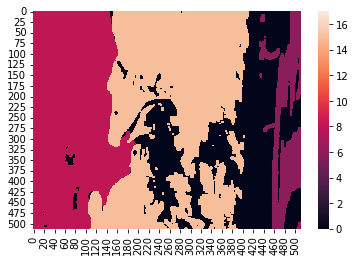

In [98]:
sns.heatmap(masks[index][..., 0], vmax=17)

<AxesSubplot:>

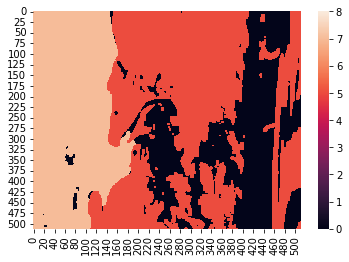

In [99]:
sns.heatmap(new_mask[..., 0], vmax=8)